In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
# if (op.first=="mu0") {
# hpipm_options_.mu0 = op.second;
# } else if (op.first=="alpha_min") {
# hpipm_options_.alpha_min = op.second;
# } else if (op.first=="res_g_max") {
# hpipm_options_.res_g_max = op.second;
# } else if (op.first=="res_b_max") {
# hpipm_options_.res_b_max = op.second;
# } else if (op.first=="res_d_max") {
# hpipm_options_.res_d_max = op.second;
# } else if (op.first=="res_m_max") {
# hpipm_options_.res_m_max = op.second;
# } else if (op.first=="iter_max") {
# hpipm_options_.iter_max = op.second;
# } else if (op.first=="stat_max") {
# hpipm_options_.stat_max = op.second;
# } else if (op.first=="pred_corr") {
# hpipm_options_.pred_corr = op.second;
# } else if (op.first=="cond_pred_corr") {
# hpipm_options_.cond_pred_corr = op.second;
# } else if (op.first=="itref_pred_max") {
# hpipm_options_.itref_pred_max = op.second;
# } else if (op.first=="itref_corr_max") {
# hpipm_options_.itref_corr_max = op.second;
# } else if (op.first=="reg_prim") {
# hpipm_options_.reg_prim = op.second;
# } else if (op.first=="lq_fact") {
# hpipm_options_.lq_fact = op.second;
# } else if (op.first=="lam_min") {
# hpipm_options_.lam_min = op.second;
# } else if (op.first=="t_min") {
# hpipm_options_.t_min = op.second;
# } else if (op.first=="warm_start") {
# hpipm_options_.warm_start = op.second;
# } else if (op.first=="abs_form") {
# hpipm_options_.abs_form = op.second;
# } else if (op.first=="comp_dual_sol_eq") {
# hpipm_options_.comp_dual_sol_eq = op.second;
# } else if (op.first=="comp_res_exit") {
# hpipm_options_.comp_res_exit = op.second;

In [3]:
m = 1
# J = 2.5 * 1e-4
J = 1e-1
l = 0.086
g = 9.81

nx = 6 #状態変数の次元
nu = 2 #制御変数の次元

# 後退ホライズン等
T = 1
K = 20
dt = T/K

#コスト行列
Q = casadi.diag([10,10,10,10,10,10])
Q_f = casadi.diag([10,10,10,10,10,10])
R = casadi.diag([0.1,0.1])

# 制約条件
x_lb = [-10,-10,-np.pi/2,-10,-10,-10]
x_ub = [10,10,np.pi/2,10,10,10]
_mg = m*g/2
u_lb = [0-_mg,0-_mg]
u_ub = [10-_mg,10-_mg]

#目標値
x_ref = casadi.DM([3,3,0,0,0,0])
# u_ref = casadi.DM([m*g/2,m*g/2])

#目標値
u_ref = casadi.DM([0,0])

total = nx*(K+1) + nu*K

#coef
A = casadi.DM.zeros(nx,nx)
A[0,3] = 1
A[1,4] = 1
A[2,5] = 1
A[3,2] = -g

B = casadi.DM.zeros(nx,nu)
B[4,0] = 1/m
B[4,1] = 1/m
B[5,0] = l/J
B[5,1] = -l/J

In [4]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    states_dot = A@states + B@ctrls

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r = f(x=states,u=ctrls)["x_dot"]

    states_next = states + dt*r

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [5]:
def make_qps():
    RK4 = make_RK4()
    eye = casadi.DM.eye(nx)

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        # eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        eq = (eye + dt*A)@X[k] + dt*B@U[k] - X[k+1]
        G.append(eq)
    J += compute_final_cost(X[-1])

    x = [X[0]]
    for k in range(K):
        x.append(U[k])
        x.append(X[k+1])

    qp = {"x":casadi.vertcat(*x),"f":J,"g":casadi.vertcat(*G)}

    opt = {
        "N":K,
        "nx":[nx]*(K+1),
        "nu":[nu]*K +[0],
        "ng":[0]*(K+1),
        "hpipm":{
            "mode":"speed_abs",
            }}

    S_hpipm = casadi.qpsol("S","hpipm",qp,opt)
    return S_hpipm

In [6]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + (u_lb+x_lb)*K
    ubx = x_init + (u_ub+x_ub)*K
    lbg = [-1e-8]*nx*K
    ubg = [1e-8]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [7]:
S_hpipm = make_qps()

nx,nu,ng[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6][2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0][0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
nus[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
nu22:20
0
625
166
3878


HPIPM finished after 9 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 7 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 9 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 9 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 8 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 7 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 7 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 7 iterations.
retur

HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
return status: 0
HPIPM residuals: 0, 0, 0, 0
HPIPM finished after 4 iterations.
retur

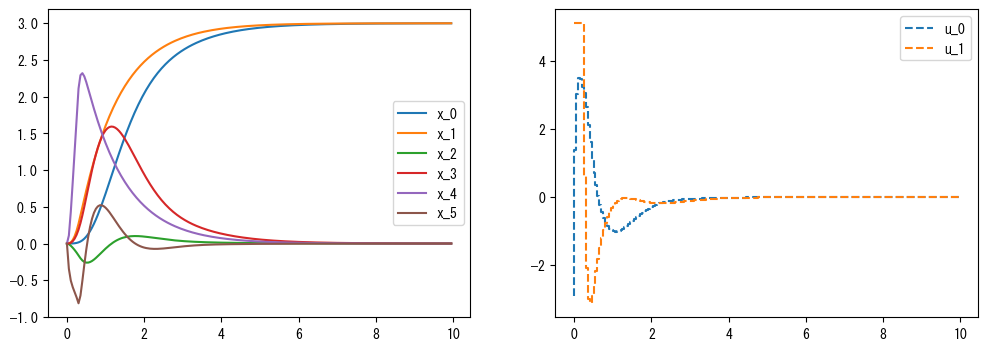

In [8]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

x0 = [x_init]
x_tmp = x_init
for i in range(K):
    x_tmp = I(x0=x_tmp)["xf"]
    x0.append(x_tmp)
u0 = casadi.DM.zeros(nu*K)
x0 = casadi.vertcat(*x0,u0)

start_time = time.perf_counter()
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_hpipm,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)
end_time = time.perf_counter()
print(f"[*] solver: hpipm, elapsed time: {end_time-start_time:1f}s")

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

# plt.savefig("images/chap7_2d_quad_mpc_osqp.png")
plt.show()